In [1]:
'''
Preparing the Dataset
'''

### Import Packages ###
import pandas as pd
import string
from cleanco import cleanco
from collections import Counter
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
%matplotlib inline

### Read the Dataset, dealing with missing values ###
missing_values = ["n/a", "na", "--"]
df = pd.read_csv('Test_Names.csv', na_values=missing_values).dropna()

### Exlpore the Dataset ###
# Checking the number of rows and cols
print(df.shape) #(105890, 2)

# Checking the number of missing values
print(df.isnull().values.sum()) 

# Dataset Preview
df.head()

/opt/homebrew/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


(105890, 2)
0


,domestic,transaction_id
0,"A Class Trading Pvt., Ltd.",1
1,"A K Y Lanka Pvt., Ltd.",2
2,"A R Freight Care Services Pvt., Ltd.",3
3,"Ace International Express Pvt., Ltd.",4
4,Aero Dynamics (Pvt) Ltd.,5


In [2]:
'''
Parsing the company names
    * Assign a group by the first letter
    * Remove the punctuations
        - Use 'string' library
    * Remove the legal control terms
        - Use 'cleanco' python library
        - Create a stopwords list
    * Lowercase the letters
    * Create a list of most common words appear in the company names to penalize when matching the names
        - Use 'collection' library
'''

# Create a Dataframe to save the matched names
df_match = pd.DataFrame(columns=['group','original','cleaned','alias','score'])
# Get a list of unique company names 
names = df['domestic'].unique()
# Sort the names in alphabetical order
names.sort()
# Assign values to the Dataframe
df_match['original'] = names
df_match['cleaned'] = names
df_match['group'] = df_match['original'].apply(lambda x: x[0])
# Parse the names - remove puctuations, legal control terms, change all to the lowercase
df_match['cleaned'] = df_match['cleaned'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df_match['cleaned'] = df_match['cleaned'].apply(lambda x: cleanco(x).clean_name())
df_match['cleaned'] = df_match['cleaned'].apply(lambda x: x.lower())
# Remove the stopwords in the company name
stopwords = ['pvt', 'exp', 'ltd', 'lt', 'co', 'corp']
df_match['cleaned'] = df_match['cleaned'].apply(lambda x: ' '.join([word for word in x.split(" ") if word not in stopwords]))

# Find the most appearing words in the company name
word_counter = Counter()
for name in df_match['cleaned'].unique():
    word_counter.update(str(name).split(" "))
key_words = [word for (word,_) in word_counter.most_common(30)]
key_words = [word for word in key_words if len(word)>3]
# Show the top 30 most common names
print(key_words)

# Dataset preview
df_match.head()

['lanka', 'international', 'trading', 'ceylon', 'enterprises', 'holdings', 'industries', 'products', 'global', 'gems', 'engineering', 'services', 'food', 'logistics']


,group,original,cleaned,alias,score
0,(,(Camso Loadstar ( Pivt ) Ltd.),camso loadstar pivt,NaN,NaN
1,/,/Meerasahibo & Sons,meerasahibo sons,NaN,NaN
2,1,1 Billabong Place Burleigh,1 billabong place burleigh,NaN,NaN
3,1,1/138 Colonial Drive,1138 colonial drive,NaN,NaN
4,1,1/F Block A Emerald Gardens,1f block a emerald gardens,NaN,NaN


In [3]:
def check_keywords(name):
    '''
    Return if the keyword exist in the name
    '''
    is_key_in_name = True
    for word in key_words:
        if word in name:
            is_key_in_name = False
    return is_key_in_name

# Get unique groups of the names - first letter of the names
sort_groups = df_match['group'].unique()

'''
Matching the company names
    * For each alphabet group, check the similarity scores with other grouped names
        - Use 'fuzzywuzzy' package
        : fuzzywuzzy uses the 'levenshtein' distance to calculate the similarity
        : fuzzywuzzy takes the whitespace into account as well as the order of the words
'''

def match_levenshtein(df_match, start_idx, end_idx, parsed_col='cleaned', alias_col='alias', score_col='score'):
    for i in range(start_idx, end_idx+1):
        if pd.isna(df_match[alias_col].iloc[i]):
            df_match[alias_col].iloc[i] = df_match[parsed_col].iloc[i]
            df_match[score_col].iloc[i] = 100

        for j in range(i+1, end_idx+1):
            if pd.isna(df_match[alias_col].iloc[j]):
                match_score = fuzz.token_sort_ratio(df_match[parsed_col].iloc[i],df_match[parsed_col].iloc[j])
                if not check_keywords(df_match[parsed_col].iloc[j]):
                    match_score -= 20
                if (match_score > 80):
                    df_match[alias_col].iloc[j] = df_match[alias_col].iloc[i]
                    df_match[score_col].iloc[j] = match_score
                    
    return None

# Match the names for each name group
for group in sort_groups:
    curr_group = df_match.groupby(['group']).get_group(group)
    start_idx = curr_group.index.min()
    end_idx = curr_group.index.max()
    
    match_levenshtein(df_match, start_idx, end_idx)
            
# Assign a unique identifier to each alias name
df_match = df_match.assign(uid=(df_match['alias'].astype('category').cat.codes))

df_match.head()

,group,original,cleaned,alias,score,uid
0,(,(Camso Loadstar ( Pivt ) Ltd.),camso loadstar pivt,camso loadstar pivt,100,1885
1,/,/Meerasahibo & Sons,meerasahibo sons,meerasahibo sons,100,7437
2,1,1 Billabong Place Burleigh,1 billabong place burleigh,1 billabong place burleigh,100,1
3,1,1/138 Colonial Drive,1138 colonial drive,1138 colonial drive,100,2
4,1,1/F Block A Emerald Gardens,1f block a emerald gardens,1f block a emerald gardens,100,4


In [4]:
'''
Merging the original dataset with the matched name dataset

'''

# Change the 'original' column name to 'domestic' to match with the original dataset
df_match['domestic'] = df_match['original']

# Merge two datasets
df_final = pd.merge(df['domestic'], df_match[['domestic', 'alias', 'uid']], on='domestic')

# Checking the number of rows and cols
print(df_final.shape) #(105890, 3)

# Preview the dataset
df_final.head()

(105890, 3)


,domestic,alias,uid
0,"A Class Trading Pvt., Ltd.",a class trading,75
1,"A Class Trading Pvt., Ltd.",a class trading,75
2,"A Class Trading Pvt., Ltd.",a class trading,75
3,"A Class Trading Pvt., Ltd.",a class trading,75
4,"A K Y Lanka Pvt., Ltd.",a k y lanka,115


In [5]:
# Reformat the final dataset
df_final = df_final[['domestic', 'uid']]

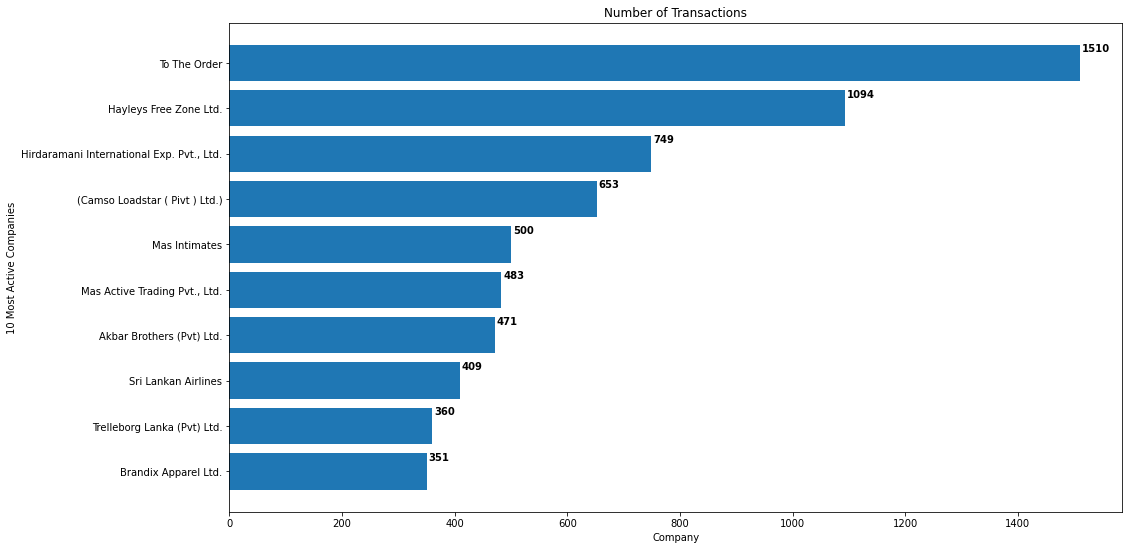

In [20]:
'''
Identifying the 10 most active firms

'''

# Count the occurence for each 'alias' value
count = df_final['domestic'].value_counts().head(10)
count = count.sort_values(ascending=True)

# Create a chart to present the result
names = count.index
values = count.values
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(names, values)
plt.xlabel("NUmber of Transactions")
plt.xticks()
for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='black', fontweight='bold')
plt.ylabel("10 Most Active Companies")
plt.show()

In [21]:
# Save the result to the local directory

df_final.to_csv("final_df.csv")
count.to_csv("active_companies_df.csv")
fig.savefig("active_companies_chart.png")